In [1]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
     
traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory=False)

traindf.dropna(inplace = True)

def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    df.drop(columns = ['Name'],inplace = True)
    return df
traindf = split_names(traindf)


def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df
traindf = split_group_number(traindf)
testdf = split_group_number(testdf)


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
def proportion_same_lastname_in_cabin(df):
    same_lastname_count = 0
    total_count = 0
    grouped = df.groupby('Cabin')
    
    for cabin, cabin_df in grouped:
        unique_last_name_values = cabin_df['LastName'].dropna().unique()
        
        if len(unique_last_name_values) == 1:
            same_lastname_count += len(cabin_df)
        
        total_count += len(cabin_df)
    
    proportion = same_lastname_count / total_count
    return proportion

proportion = proportion_same_lastname_in_cabin(traindf)
print(f"The proportion of people with the same last name in the same cabin is: {proportion:.2%}")


The proportion of people with the same last name in the same cabin is: 91.20%


In [51]:
def cabins_with_multiple_last_names(df):
    cabins = []
    grouped = df.groupby(['Cabin','CryoSleep'])

    for cabin, cabin_df in grouped:
        unique_last_name_values = cabin_df['LastName'].dropna().unique()
        
        if len(unique_last_name_values) > 1:
            cabins.append(cabin)
    
    return cabins

cabins_without_same_last_names = cabins_with_multiple_last_names(traindf)
print("Cabins where people don't share the same last name:")
print(cabins_without_same_last_names)


Cabins where people don't share the same last name:
[('A/103/S', False), ('A/104/S', False), ('A/14/S', True), ('A/20/S', False), ('A/22/P', False), ('A/52/P', False), ('A/75/P', False), ('A/8/S', False), ('A/80/S', False), ('A/82/S', False), ('A/9/P', False), ('A/91/P', False), ('A/97/S', False), ('B/118/P', True), ('B/125/S', False), ('B/15/S', True), ('B/150/P', True), ('B/177/P', True), ('B/18/P', True), ('B/194/S', True), ('B/201/P', False), ('B/201/P', True), ('B/202/S', True), ('B/216/P', False), ('B/218/S', True), ('B/230/S', False), ('B/238/P', False), ('B/251/S', False), ('B/254/S', False), ('B/258/S', False), ('B/270/P', False), ('B/279/S', True), ('B/297/P', False), ('B/61/S', True), ('B/62/S', False), ('B/63/S', False), ('B/82/S', True), ('B/99/S', False), ('C/100/S', False), ('C/125/S', False), ('C/137/S', True), ('C/156/S', False), ('C/176/S', False), ('C/187/S', False), ('C/198/S', True), ('C/201/P', False), ('C/220/S', True), ('C/225/P', False), ('C/235/S', False), ('C

In [80]:
traindf[traindf.Cabin == cabins_without_same_last_names[24][0]]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Group,GroupNumber
5317,5684_02,Europa,True,B/218/S,55 Cancri e,48.0,False,0.0,0.0,0.0,0.0,0.0,True,Azhah,Busive,5684,02
5318,5684_03,Europa,False,B/218/S,55 Cancri e,38.0,False,0.0,1198.0,48.0,278.0,1244.0,False,Genubik,Busive,5684,03
5319,5684_04,Europa,True,B/218/S,TRAPPIST-1e,62.0,False,0.0,0.0,0.0,0.0,0.0,True,Okulus,Folhal,5684,04


In [48]:
def proportion_one_person_spent_on_room_service(df):
    cabin_counts = df[df['VRDeck'] > 0].groupby('Cabin')['PassengerId'].count()
    one_person_cabins = cabin_counts[cabin_counts == 1].index
    total_cabins = len(cabin_counts)
    one_person_cabins_count = len(one_person_cabins)

    if total_cabins > 0:
        proportion = one_person_cabins_count / total_cabins
    else:
        proportion = 0.0

    return proportion

proportion = proportion_one_person_spent_on_room_service(traindf)

print(f"The proportion of cabins meeting the criteria is: {proportion:.2%}")


The proportion of cabins meeting the criteria is: 92.18%


In [35]:
cabin_counts = traindf[traindf['RoomService'] > 0].groupby('Cabin')['PassengerId'].count()


Cabin
A/0/S      False
A/1/S      False
A/10/S     False
A/107/S    False
A/13/P     False
           ...  
G/981/S    False
G/982/P    False
G/984/S    False
G/985/S    False
G/987/S    False
Name: PassengerId, Length: 2179, dtype: bool

In [45]:
def proportion_cabins_with_room_service_size_2(df):
    cabins_with_two_passengers = df[df['Cabin'].duplicated(keep=False) & (df['Cabin'].notna())]
    cabins_with_room_service_size_2 = cabins_with_two_passengers[cabins_with_two_passengers['RoomService'] > 0]
    
    if len(cabins_with_two_passengers) > 0:
        proportion = len(cabins_with_room_service_size_2) / len(cabins_with_two_passengers)
    else:
        proportion = 0.0

    return proportion

proportion = proportion_cabins_with_room_service_size_2(traindf)
print(f"Total Cabins with 2 Passengers: {len(traindf[traindf['Cabin'].duplicated(keep=False) & (traindf['Cabin'].notna())]['Cabin'].unique())}")
print(f"The proportion of cabins of size 2 with money spent on room service is: {proportion:.2%}")


Total Cabins with 2 Passengers: 831
The proportion of cabins of size 2 with money spent on room service is: 22.37%


In [39]:
len(set(traindf.Cabin.values))

5305

In [ ]:
traindf[traindf[]]

In [49]:
traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'FirstName', 'LastName', 'Group', 'GroupNumber'],
      dtype='object')

In [50]:
def family_transported(df):
    def determine_family_status(row):
        same_last_name_group = traindf[(traindf['LastName'] == row['LastName']) & (traindf.index != row.name)]
        same_last_name_group = same_last_name_group[same_last_name_group['HomePlanet'] == row['HomePlanet']]
        same_last_name_group = same_last_name_group[same_last_name_group['Destination'] == row['Destination']]

        if len(same_last_name_group) == 0:
            return 'nofam'
        elif any(same_last_name_group['Transported']):
            return 'True'
        else:
            return 'False'

    df['FamilyTransported'] = df.apply(determine_family_status, axis=1)
    return df

# Assuming traindf is your DataFrame containing information about '
traindf = family_transported(traindf)


In [51]:
traindf[traindf.LastName == 'Vines']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Group,GroupNumber,FamilyTransported
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,0002,01,True
5455,5816_01,Earth,False,G/937/P,TRAPPIST-1e,31.0,False,1.0,0.0,7.0,0.0,387.0,True,Armene,Vines,5816,01,True
7623,8143_01,Earth,False,F/1558/S,TRAPPIST-1e,18.0,False,0.0,17.0,5.0,0.0,712.0,True,Sergia,Vines,8143,01,True


In [52]:
traindf[traindf.FamilyTransported == 'True']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Group,GroupNumber,FamilyTransported
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,0002,01,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Altark,Susent,0003,01,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Solam,Susent,0003,02,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,Erraiam,Flatic,0008,01,True
11,0008_03,Europa,False,B/1/P,55 Cancri e,45.0,False,39.0,7295.0,589.0,110.0,124.0,True,Wezena,Flatic,0008,03,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8683,9272_02,Earth,False,F/1894/P,TRAPPIST-1e,21.0,False,86.0,3.0,149.0,208.0,329.0,False,Gordo,Simson,9272,02,True
8685,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,Polaton,Conable,9275,01,True
8686,9275_02,Europa,False,A/97/P,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,False,Diram,Conable,9275,02,True
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,Gravior,Noxnuther,9276,01,True


In [53]:
traindf.FamilyTransported.value_counts()

FamilyTransported
True     3528
nofam    1674
False    1404
Name: count, dtype: int64

In [54]:
splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)
xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

In [63]:
m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)


DecisionTreeRegressor(max_leaf_nodes=20)

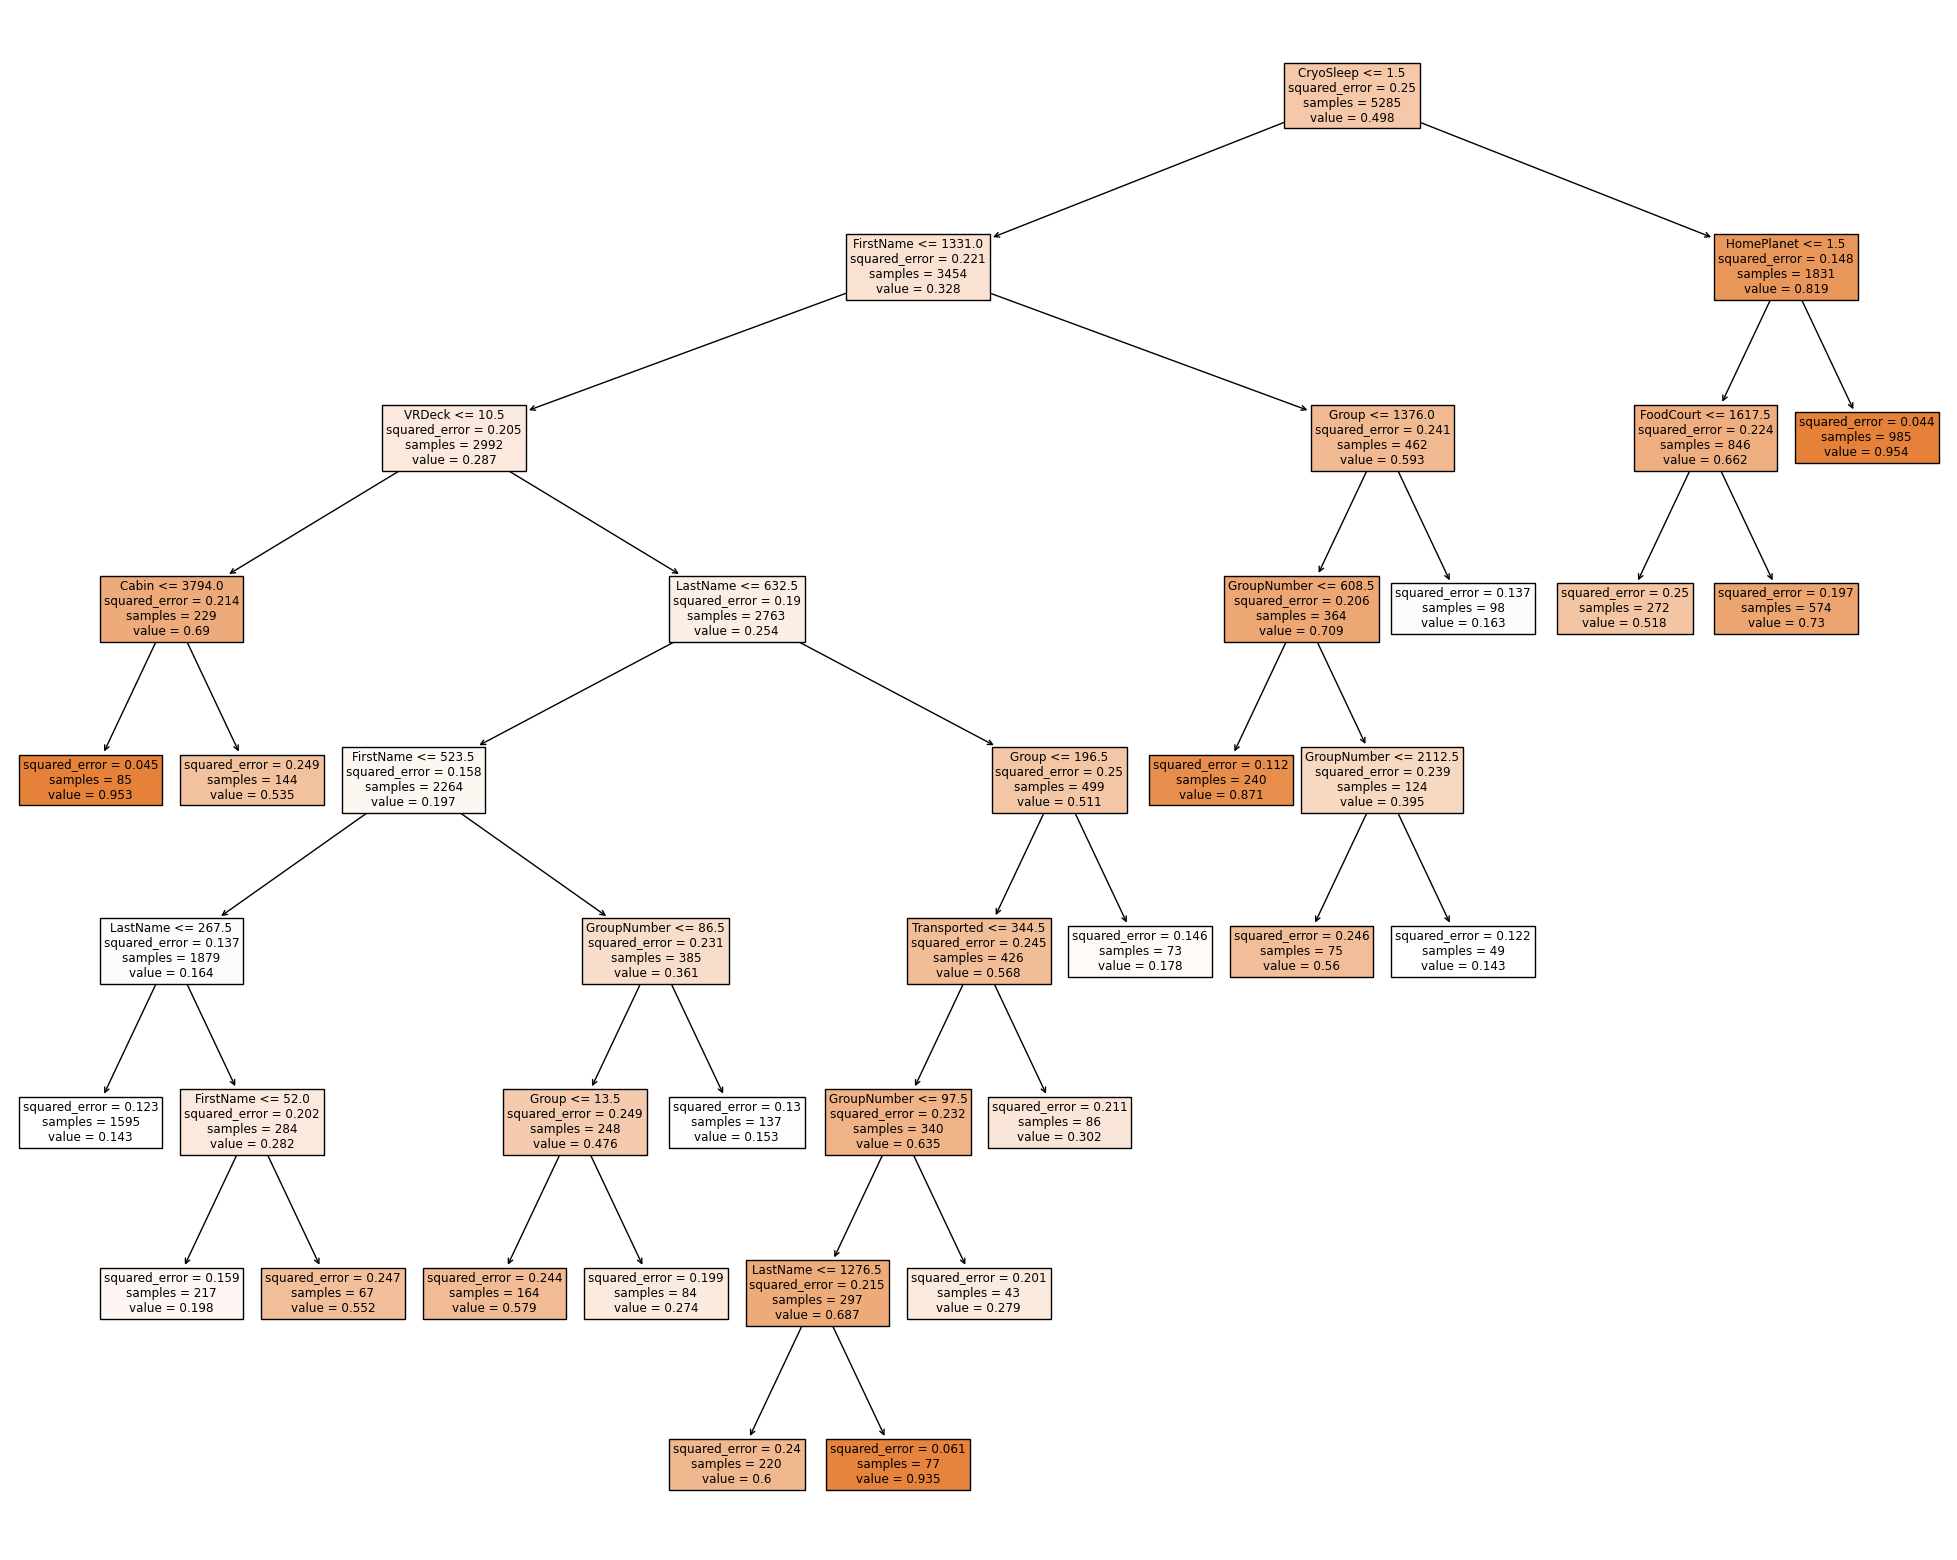

In [64]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   
                   filled=True)

In [65]:
((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y)


0.79333838001514

In [66]:
m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print(mean_absolute_error(valid_y, preds))
(preds == valid_y).sum() /len(valid_y)


0.19984859954579864


0.8001514004542014

In [59]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:30]

,cols,imp
2,CryoSleep,0.202942
15,Spa,0.141857
16,VRDeck,0.132338
12,RoomService,0.118264
13,FoodCourt,0.091442
14,ShoppingMall,0.081074
3,Cabin,0.071540
1,HomePlanet,0.049629
11,Age,0.033112
8,Group,0.017065
